## Potato Disease Classification
### Import all the Dependencies


In [1]:
# Import core numerical computing library for handling arrays and matrices
import numpy as np

# Import the os module to interact with the operating system (e.g., reading directory paths)
import os

# Import Keras model and layer building blocks
from tensorflow.keras import models, layers

# Import ImageDataGenerator for image preprocessing and augmentation (training/validation generators)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import utilities to load and preprocess individual images
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

# Import TensorFlow itself (high-level interface and backend engine)
import tensorflow as tf

# Import Matplotlib for visualizing training performance (e.g., loss and accuracy)
import matplotlib.pyplot as plt

# Import Keras backend, often used for clearing memory/session or getting low-level TensorFlow features
from tensorflow.keras import backend as K


### Set all the Constants

In [19]:
IMAGE_SIZE = 256                # Target size to resize all images
BATCH_SIZE = 32                 # Number of images processed in one batch
AUTOTUNE = tf.data.AUTOTUNE     # Lets tf optimize data loading performance
EPOCHS = 50                     # Number of full training cycles through the dataset
CHANNELS = 3                    # RGB images have 3 color channels (Red, Green, Blue)


## Initializing, Exploring & Partioning the Dataset
### Function to Split Dataset
Dataset should be classified into 3 subsets, namely:

1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [3]:
# Function to split a TensorFlow dataset into train, validation, and test sets
def get_dataset_partitions_tf(
    ds,                      # The original dataset
    train_split=0.8,         # Fraction of data for training (80%)
    val_split=0.1,           # Fraction for validation (10%)
    test_split=0.1,          # Fraction for testing (10%)
    shuffle=True,            # Whether to shuffle the dataset before splitting
    shuffle_size=10000       # Number of elements to use when shuffling
):
    # Ensure the splits add up to 100% of the dataset
    assert (train_split + test_split + val_split) == 1

    # Get the total number of items in the dataset
    ds_size = ds.cardinality().numpy()

    # Shuffle the dataset for randomness which is important before splitting
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    # Calculate how many samples go into each split
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    # Split the dataset:
    train_ds = ds.take(train_size)  # Take the first N items for training
    val_ds = ds.skip(train_size).take(val_size)  # Skip training items, then take next N for validation
    test_ds = ds.skip(train_size).skip(val_size)  # Skip both training and validation, use remaining for test

    return train_ds, val_ds, test_ds  # Return the three datasets


### Reading and Partitioning the Dataset
We create a Tensorflow Dataset Object and directly read it from the directory using image_dataset_from_directory and then split it using the function we created above

In [4]:
# Load images from the 'PlantVillage' directory and automatically label them based on subfolder names
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",                       # Root directory containing class subfolders
    shuffle=True,                         # Shuffle the data for better training
    image_size=(IMAGE_SIZE, IMAGE_SIZE),  # Resize all images to the same dimensions
    batch_size=BATCH_SIZE                 # Number of images in each batch
)

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 2152 files belonging to 3 classes.


### Checking the Available Classes

In [5]:
# Get the list of class names (from subfolder names in the dataset directory)
class_names = dataset.class_names

# Count how many classes there are
n_classes = len(class_names)

# Print the number of classes and their names
print(n_classes, class_names)


3 ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


## Displaying Some Sample Images

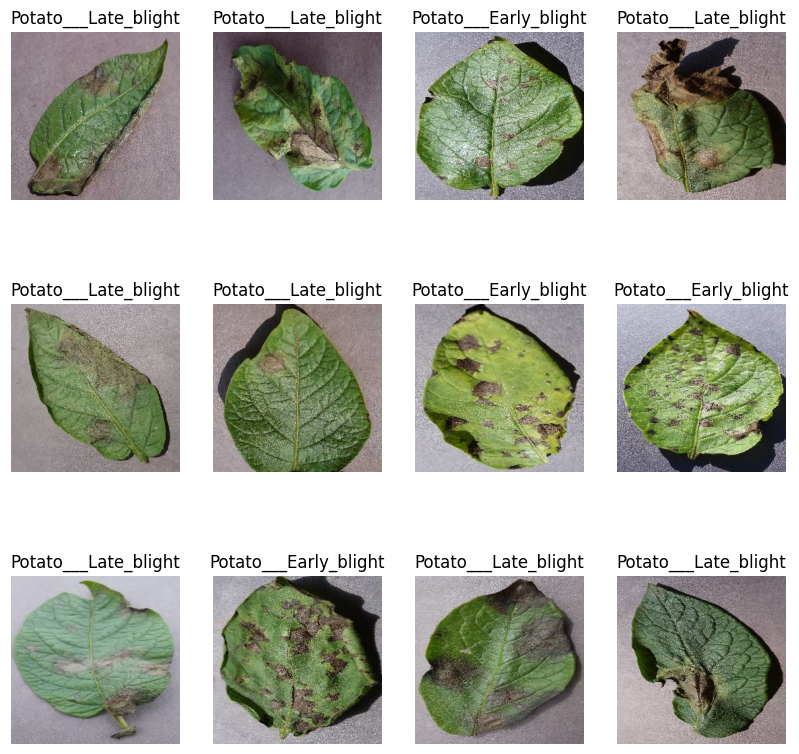

In [6]:
# Create a 10x10 inch figure for displaying images
plt.figure(figsize=(10, 10))

# Take the first batch from the dataset
for image_batch, label_batch in dataset.take(1):
    # Show the first 12 images in the batch
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)                       # Create a 3x4 grid of subplots
        plt.imshow(image_batch[i].numpy().astype("uint8"))  # Display the image
        plt.title(class_names[label_batch[i]])              # Add the class name as the title
        plt.axis("off")                                     # Hide axis ticks


## Checking Batch Size

In [7]:
# Loop through one batch in the training dataset
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)   # Shape of the image batch: (batch_size, height, width, channels)
    print(labels_batch.shape)  # Shape of the label batch: (batch_size,)
    break                      # Only check the first batch


(32, 256, 256, 3)
(32,)


### Cache, Shuffle, and Prefetch the Dataset

In [8]:
# Optimize the training dataset pipeline:
# - cache() stores data in memory after first load
# - shuffle(1000) adds randomness
# - prefetch() overlaps data preprocessing and model execution for speed
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Apply the same optimizations to validation and test datasets
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)


## Building the Model
### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [9]:
# Preprocessing layer to standardize image input
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Resize all images to a fixed size (256x256)
    tf.keras.layers.Rescaling(1./255)                  # Normalize pixel values from [0, 255] to [0, 1]
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [10]:
# Data augmentation layer to create random variations of input images during training
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images in both directions
    tf.keras.layers.RandomRotation(0.2)                     # Randomly rotate images by up to 20%
])


### Checking what is the expected dimension order for channel

In [14]:
# Basic info about the image
# 256x256 pixels, and 3 channels (RGB)
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Same as input_shape, but includes batch size (how many images the model sees at once)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# This tells TensorFlow where the "channel" (color) information is stored
# -1 means the last position (e.g. RGB is at the end: H x W x 3)
chanDim = -1

# If you're using a different backend (like Theano), it stores channels in a different order
# This just adjusts the shapes to match that style
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)  # Now channel comes first
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1  # Channel is in position 1


## Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [17]:
model = models.Sequential([
    # Preprocessing layers  
    resize_and_rescale,                        # Resize and normalize images
    data_augmentation,                         # Apply random flip and rotation (for training only)

    # Convolutional layers for feature extraction
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),  # First conv layer
    layers.MaxPooling2D((2, 2)),                                                        # Reduce spatial size

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),   # More filters, deeper features
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Classification layers
    layers.Flatten(),                          # Flatten feature maps into a 1D vector
    layers.Dense(64, activation='relu'),       # Fully connected layer
    layers.Dense(n_classes, activation='softmax')  # Output layer (one neuron per class) and "softmax" it will normalise the probability of the classes
])

# Define the shape of input expected by the model (e.g., (None, 256, 256, 3))
model.build(input_shape=batch_input_shape)


### Model Summary

In [18]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [20]:
model.compile(
    optimizer='adam',  # Optimizer that adjusts weights to minimize loss (Adam works well for most cases)
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  
    # Use this loss because labels are integers, not one-hot encoded
    # from_logits=False means the model already ends with a softmax layer

    metrics=['accuracy']  # Track how often predictions match labels
)

## Training the Network

In [21]:
history = model.fit(
    train_ds,                      # Training dataset
    batch_size=BATCH_SIZE,        # Number of samples per training step (already set in dataset)
    validation_data=val_ds,       # Data to validate model on after each epoch
    verbose=1,                    # 1 = show progress bar, 0 = silent, 2 = one line per epoch
    epochs=EPOCHS                 # Number of times to train over the full dataset
)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 59s 934ms/step - accuracy: 0.4830 - loss: 0.9359 - val_accuracy: 0.5417 - val_loss: 0.8879
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 796ms/step - accuracy: 0.6352 - loss: 0.8358 - val_accuracy: 0.7708 - val_loss: 0.5096
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 878ms/step - accuracy: 0.7746 - loss: 0.4722 - val_accuracy: 0.8594 - val_loss: 0.3242
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 829ms/step - accuracy: 0.8349 - loss: 0.4037 - val_accuracy: 0.9167 - val_loss: 0.2226
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 814ms/step - accuracy: 0.8433 - loss: 0.3848 - val_accuracy: 0.8802 - val_loss: 0.2816
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 811ms/step - accuracy: 0.8960 - loss: 0.2561 - val_accuracy: 0.8698 - val_loss: 0.3633
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 801ms/step - accuracy: 0.8835 - loss: 0.3075 - val_accuracy: 0.9427 - val_loss: 0.1823
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 771ms/step - accuracy: 0.8969 - loss: 0.2356 - val_accu

### Testing the Model

In [22]:
print("[INFO] Calculating model accuracy")

# Evaluate the model on the test dataset
scores = model.evaluate(test_ds)

# scores[1] = accuracy (since you used 'accuracy' in model.compile)
print(f"Test Accuracy: {round(scores[1], 4) * 100}%")
  

[INFO] Calculating model accuracy
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step - accuracy: 0.9636 - loss: 0.1046
Test Accuracy: 97.66%


### Plotting the Accuracy and Loss Curves

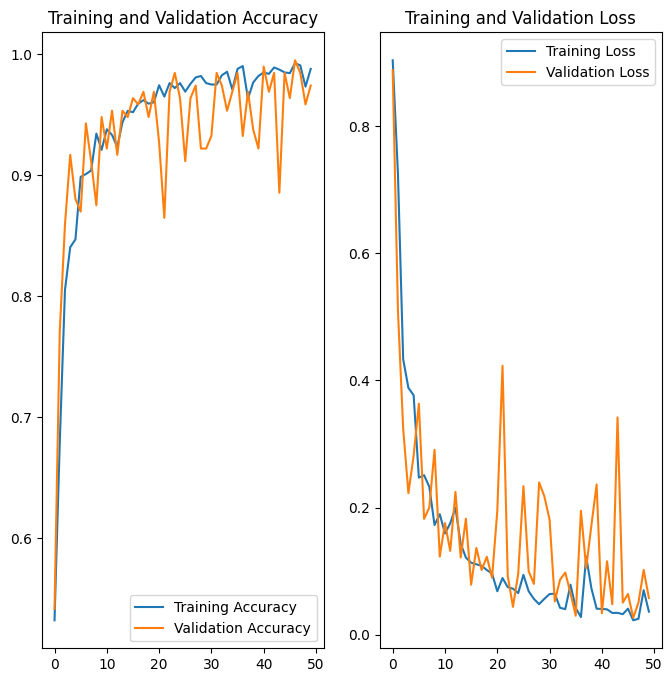

In [23]:
# Get accuracy and loss values from the training history
acc = history.history['accuracy']         # Accuracy on training data
val_acc = history.history['val_accuracy'] # Accuracy on validation data
loss = history.history['loss']            # Training loss
val_loss = history.history['val_loss']    # Validation loss

# Create a range from 0 to number of epochs
epochs_range = range(EPOCHS)

# Set up the plot area
plt.figure(figsize=(8, 8))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Show both plots
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
predicted label: Potato___Late_blight


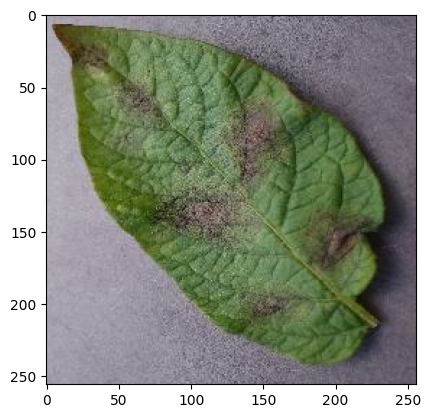

In [31]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

### Function for Inference

In [32]:
def predict(model, img):
    # Turn the image into a format the model understands (numbers)
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Add one extra dimension so it looks like a batch of 1 image
    img_array = tf.expand_dims(img_array, 0)

    # Ask the model to make a prediction
    predictions = model.predict(img_array)

    # Find the class (label) with the highest score
    predicted_class = class_names[np.argmax(predictions[0])]

    # Get how confident the model is about this prediction
    confidence = round(np.max(predictions[0]) * 100, 2)

    return predicted_class, confidence


### Plotting the Inference Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


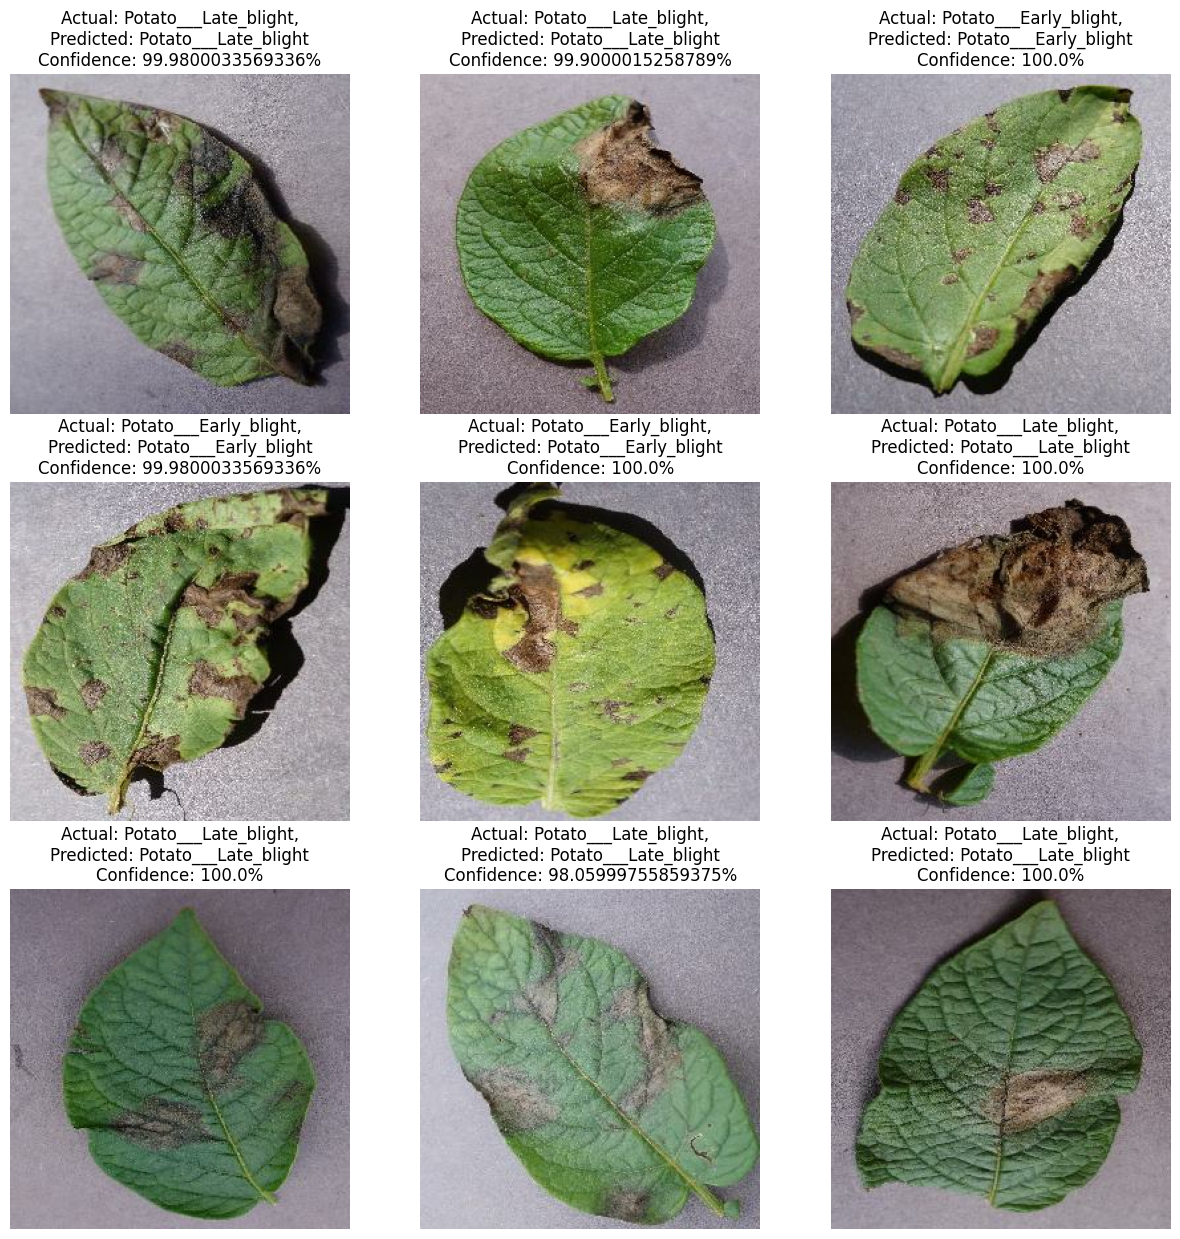

In [33]:
# Set the overall figure size
plt.figure(figsize=(15, 15))

# Take one batch from the test dataset
for images, labels in test_ds.take(1):
    # Show 9 images from that batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)  # Create a 3x3 grid of plots

        # Show the image
        plt.imshow(images[i].numpy().astype("uint8"))

        # Predict the class and confidence
        predicted_class, confidence = predict(model, images[i].numpy())

        # Get the actual class label
        actual_class = class_names[labels[i]]

        # Add title showing actual and predicted class
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")  # Hide the axes for a cleaner look


## Saving the Model
We append the model to the list of models as a new version

In [35]:
import os

# Check the "../models" folder for existing saved models
# Convert their names to integers (e.g., "1", "2", "3") and get the highest one
# If the folder is empty, start at 0
model_version = max([int(i) for i in (os.listdir("../models") + ["0"])]) + 1

# Save the trained model to a new folder named with the next version number
model.save(f"../models/{model_version}.keras")  # ✅ modern format
